# CNN LeNet para Clasificación de Señales de Tráfico

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import pickle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
dir_datos = "LABORATORIO2_DS"

In [4]:
os.listdir(dir_datos)[0]

'.ipynb_checkpoints'

In [5]:
trayecto_test = dir_datos + '/prueba.p'
trayecto_train = dir_datos + '/entrenamiento.p'
trayecto_val = dir_datos + '/validacion.p'

In [6]:
def cargar_datos(ruta):
    with open(ruta, 'rb') as file:
        datos = pickle.load(file)
    return datos

In [7]:
datos_prueba = cargar_datos(trayecto_test)
datos_entrenamiento = cargar_datos(trayecto_train)
datos_validacion = cargar_datos(trayecto_val)

In [8]:
# After loading the 'images' from the pickle file:

# Print the type of the object
print(type(datos_entrenamiento))

# If it's a dictionary, print its keys
if isinstance(datos_entrenamiento, dict):
    print(datos_entrenamiento.keys())

<class 'dict'>
dict_keys(['coords', 'labels', 'features', 'sizes'])


In [9]:
for key, value in datos_entrenamiento.items():
    print(f"{key}: Type = {type(value)}, Length/Shape = {len(value) if isinstance(value, (list, dict)) else (value.shape if hasattr(value, 'shape') else 'N/A')}")


coords: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 4)
labels: Type = <class 'numpy.ndarray'>, Length/Shape = (34799,)
features: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 32, 32, 3)
sizes: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 2)


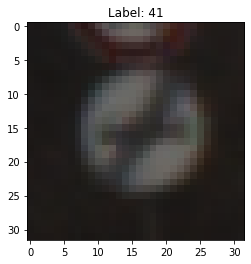

In [10]:
plt.imshow(datos_entrenamiento['features'][1])
plt.title(f"Label: {datos_entrenamiento['labels'][1]}")
plt.show()

In [11]:
# 1. Normalizar las imágenes
X_entrenamiento = datos_entrenamiento['features'] / 255.0
X_prueba = datos_prueba['features'] / 255.0
X_validacion = datos_validacion['features'] / 255.0

In [12]:
# 2. One-Hot Encoding para las etiquetas
Y_entrenamiento = to_categorical(datos_entrenamiento['labels'])
Y_prueba = to_categorical(datos_prueba['labels'])
Y_validacion = to_categorical(datos_validacion['labels'])

# Verificar las dimensiones de los datos procesados
print("X_entrenamiento shape:", X_entrenamiento.shape)
print("Y_entrenamiento shape:", Y_entrenamiento.shape)
print("X_prueba shape:", X_prueba.shape)
print("Y_prueba shape:", Y_prueba.shape)
print("X_validacion shape:", X_validacion.shape)
print("Y_validacion shape:", Y_validacion.shape)

X_entrenamiento shape: (34799, 32, 32, 3)
Y_entrenamiento shape: (34799, 43)
X_prueba shape: (12630, 32, 32, 3)
Y_prueba shape: (12630, 43)
X_validacion shape: (4410, 32, 32, 3)
Y_validacion shape: (4410, 43)


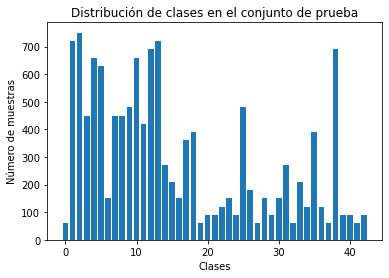

In [13]:
# Visualizar distribución de clases
unique, counts = np.unique(np.argmax(Y_prueba, axis=1), return_counts=True)
plt.bar(unique, counts)
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.show()

In [14]:
dict(zip(unique, counts))

{0: 60,
 1: 720,
 2: 750,
 3: 450,
 4: 660,
 5: 630,
 6: 150,
 7: 450,
 8: 450,
 9: 480,
 10: 660,
 11: 420,
 12: 690,
 13: 720,
 14: 270,
 15: 210,
 16: 150,
 17: 360,
 18: 390,
 19: 60,
 20: 90,
 21: 90,
 22: 120,
 23: 150,
 24: 90,
 25: 480,
 26: 180,
 27: 60,
 28: 150,
 29: 90,
 30: 150,
 31: 270,
 32: 60,
 33: 210,
 34: 120,
 35: 390,
 36: 120,
 37: 60,
 38: 690,
 39: 90,
 40: 90,
 41: 60,
 42: 90}

In [15]:
import sklearn
from imblearn.over_sampling import SMOTE

# Aplanar las imágenes
X_entrenamiento_flattened = X_entrenamiento.reshape(X_entrenamiento.shape[0], -1)
Y_entrenamiento_labels = np.argmax(Y_entrenamiento, axis=1)  # Convertir de one-hot a labels

# Aplicar SMOTE
smote = SMOTE()
X_entrenamiento_resampled, Y_entrenamiento_resampled = smote.fit_resample(X_entrenamiento_flattened, Y_entrenamiento_labels)

# Reformatear las imágenes a su forma original y las etiquetas a one-hot encoding
X_entrenamiento_resampled = X_entrenamiento_resampled.reshape((-1, 32, 32, 3))
Y_entrenamiento_resampled = to_categorical(Y_entrenamiento_resampled)


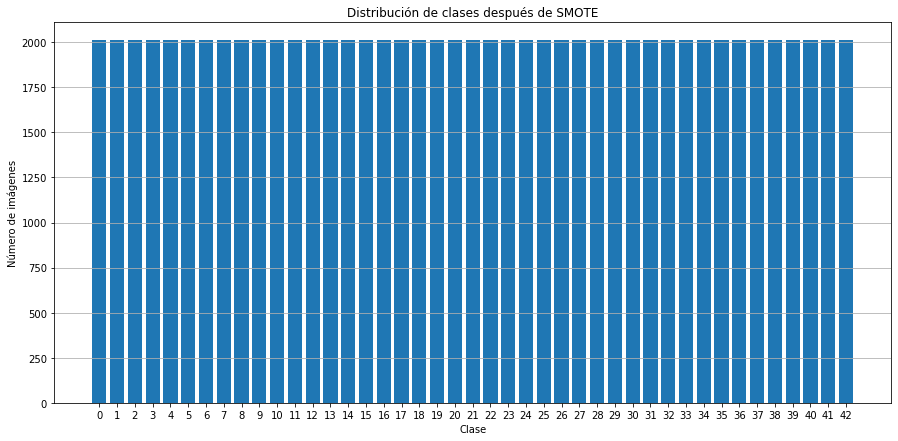

In [16]:
# Convertir de one-hot a labels
Y_entrenamiento_resampled_labels = np.argmax(Y_entrenamiento_resampled, axis=1)

# Contar las ocurrencias de cada etiqueta
unique, counts = np.unique(Y_entrenamiento_resampled_labels, return_counts=True)

# Visualizar las ocurrencias
plt.figure(figsize=(15,7))
plt.bar(unique, counts)
plt.title('Distribución de clases después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
"""datagen = ImageDataGenerator(
    rotation_range=10,         # Pequeñas rotaciones aleatorias
    width_shift_range=0.1,     # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,    # Desplazamiento vertical aleatorio
    zoom_range=0.1,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Método para rellenar puntos fuera de la imagen original
)"""

datagen = ImageDataGenerator(
    rotation_range=15,          # Aumentamos el rango de rotación
    width_shift_range=0.15,     # Aumentamos el desplazamiento horizontal
    height_shift_range=0.15,    # Aumentamos el desplazamiento vertical
    zoom_range=0.15,            # Aumentamos el rango de zoom
    horizontal_flip=True,       
    fill_mode='nearest'         
)

In [19]:
datagen.fit(X_entrenamiento)

## Arquitectura LeNet:

LeNet es una arquitectura de red neuronal convolucional diseñada principalmente para la clasificación de imágenes. En este proyecto, se utiliza para clasificar señales de tráfico.

### Capas en el Modelo:

- **Capa Convolutiva 1**: 
  - Utiliza 6 filtros de tamaño 5x5.
  - Función de activación 'tanh'.
  - Padding "same", lo que significa que la salida tiene el mismo tamaño que la entrada.

- **Capa de Pooling 1**: 
  - Realiza un pooling promedio de tamaño 2x2.

- **Capa Convolutiva 2**: 
  - Utiliza 16 filtros de tamaño 5x5.
  - Función de activación 'tanh'.
  - Sin padding.

- **Capa de Pooling 2**: 
  - Similar a la primera capa de pooling con un tamaño de 2x2.

- **Aplanado (Flatten)**: 
  - Convierte la salida en un vector 1D.

- **Capa Densa 1**: 
  - Consta de 120 neuronas con función de activación 'tanh'.

- **Capa Densa 2**: 
  - Consta de 84 neuronas con función de activación 'tanh'.

- **Capa de Salida**: 
  - Consta de 43 neuronas, correspondientes a las 43 clases de señales de tráfico.
  - Utiliza una función de activación 'softmax' para obtener probabilidades.


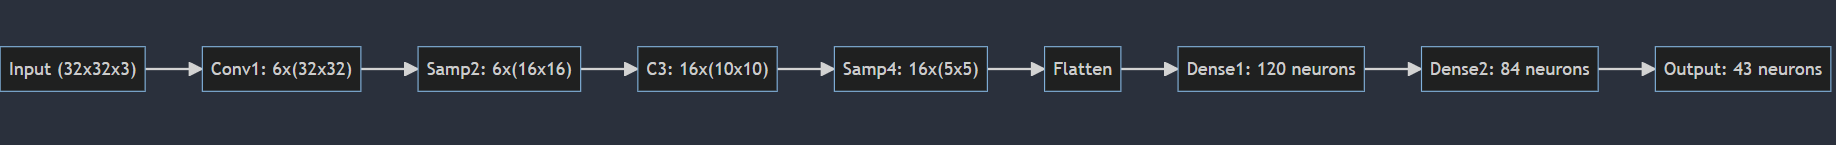

## Proceso de Convolución, Función de Activación y Pooling:

- **Convolución**: Proceso que aplica filtros a la imagen para detectar características como bordes, texturas, entre otros.
- **Función de Activación**: Transforma la salida de la capa. En este caso, se utiliza 'tanh', que transforma los valores a un rango entre -1 y 1.
- **Pooling**: Reduce la dimensión espacial de la entrada. En este caso, se utiliza pooling promedio.

## Función de Pérdida y Optimizador:

- **Función de Pérdida**: Mide cuán bien el modelo realiza predicciones. En este código, se utiliza "categorical_crossentropy" por tratarse de una clasificación multiclase.
- **Optimizador**: Ajusta los pesos del modelo para minimizar la función de pérdida. Aquí se utiliza "Adam", un optimizador popular que ajusta la tasa de aprendizaje durante el entrenamiento.

In [20]:
modelo_LeNet = Sequential()
# Capa convolucional 1
modelo_LeNet.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 3), padding="same"))

# Capa de subsampling (pooling) 1
modelo_LeNet.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Capa convolucional 2
modelo_LeNet.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# Capa de subsampling (pooling) 2
modelo_LeNet.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Aplanar
modelo_LeNet.add(Flatten())

# Capa completamente conectada (Dense) 1
modelo_LeNet.add(Dense(120, activation='tanh'))

# Capa completamente conectada (Dense) 2
modelo_LeNet.add(Dense(84, activation='tanh'))

# Capa de salida
modelo_LeNet.add(Dense(43, activation='softmax'))

In [21]:
modelo_LeNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Resumen del modelo
modelo_LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

## Proceso de Entrenamiento:

El modelo se entrena utilizando el conjunto de datos de entrenamiento a lo largo de 50 épocas, con un *learning rate* de 0.0001. En cada época, se evalúa tanto la función de pérdida ("loss") como la precisión ("accuracy") en los conjuntos de entrenamiento y validación. Esto permite monitorear cómo evoluciona el desempeño del modelo a medida que avanza el entrenamiento. Además, el uso de un *learning rate* adecuado es esencial para garantizar que el modelo converja de manera eficiente hacia una solución óptima sin oscilaciones excesivas o sin quedarse atascado en mínimos locales. Para evitar el sobreajuste y ahorrar tiempo de cómputo, se implementa un mecanismo de detención temprana. Este mecanismo detendrá el entrenamiento si no se observan mejorías en el error de validación durante un número específico de épocas consecutivas.


In [23]:
modelo_LeNet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


historia = modelo_LeNet.fit(
    X_entrenamiento, 
    Y_entrenamiento, 
    epochs=50,
    batch_size=32,
    validation_data=(X_validacion, Y_validacion)
    
)

# 3. Evaluar el modelo en datos de prueba
score = modelo_LeNet.evaluate(X_prueba, Y_prueba, verbose=1)
print('Pérdida en datos de prueba:', score[0])
print('Precisión en datos de prueba:', score[1])

Epoch 1/50
1088/1088 [==============================] - 10s 8ms/step - loss: 0.9042 - accuracy: 0.7629 - val_loss: 0.4904 - val_accuracy: 0.8531
Epoch 2/50
1088/1088 [==============================] - 9s 8ms/step - loss: 0.1829 - accuracy: 0.9570 - val_loss: 0.3700 - val_accuracy: 0.8896
Epoch 3/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0956 - accuracy: 0.9779 - val_loss: 0.3294 - val_accuracy: 0.8989
Epoch 4/50
1088/1088 [==============================] - 9s 8ms/step - loss: 0.0567 - accuracy: 0.9871 - val_loss: 0.3016 - val_accuracy: 0.9109
Epoch 5/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0401 - accuracy: 0.9914 - val_loss: 0.3076 - val_accuracy: 0.9125
Epoch 6/50
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0272 - accuracy: 0.9939 - val_loss: 0.2799 - val_accuracy: 0.9240
Epoch 7/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0231 - accuracy: 0.9947 - val_loss: 0.2930 - val_accur

In [24]:
perdidas = pd.DataFrame(historia.history)
perdidas.head()

,loss,accuracy,val_loss,val_accuracy
0,0.904199,0.762895,0.490380,0.853061
1,0.182851,0.956982,0.370020,0.889569
2,0.095624,0.977930,0.329354,0.898866
3,0.056693,0.987097,0.301579,0.910884
4,0.040074,0.991408,0.307627,0.912472


<AxesSubplot:>

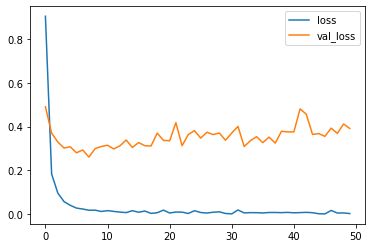

In [25]:
perdidas[['loss','val_loss']].plot()

In [29]:
modelo_LeNet.metrics_names

['loss', 'accuracy']

<AxesSubplot:>

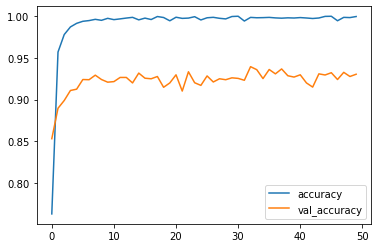

In [26]:
perdidas[['accuracy', 'val_accuracy']].plot()

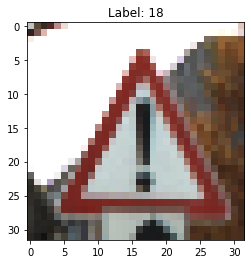

1/1 [==============================] - 0s 67ms/step
Clase predicha: 18


In [27]:
plt.imshow(datos_prueba['features'][6])
plt.title(f"Label: {datos_prueba['labels'][6]}")
plt.show()

# 1. Hacer una predicción para la imagen
probabilidades = modelo_LeNet.predict(np.expand_dims(X_prueba[6], axis=0))

# 2. Obtener la clase con la mayor probabilidad
clase_predicha = np.argmax(probabilidades, axis=-1)[0]

print("Clase predicha:", clase_predicha)

In [28]:
# Realizar predicciones con el modelo
y_pred = modelo_LeNet.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades predichas en etiquetas de clase

# Convertir las etiquetas one-hot en etiquetas de clase
y_true = np.argmax(Y_prueba, axis=1)

# Calcular métricas
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

395/395 [==============================] - 1s 3ms/step
Precision: 0.9065689488730508
Recall: 0.9039588281868567
F1-Score: 0.9032124886116157


## Métricas de Evaluación:

Además de la precisión, es útil observar otras métricas como:

- **Precisión**: Proporción de identificaciones positivas que fueron correctas.
- **Recall (Sensibilidad)**: Proporción de positivos reales que se identificaron correctamente.
- **F1-Score**: Media armónica de Precisión y Recall, proporcionando un equilibrio entre ambas métricas.

## MODELO CON MODIFICACIONES:

## Modelo LeNet Modificado:

Se ha adaptado la arquitectura LeNet para incorporar técnicas modernas de regularización y normalización con el objetivo de mejorar el desempeño y prevenir el sobreajuste. A continuación, se describen las adiciones:

1. **Batch Normalization**: 
   - Se ha añadido una capa de *Batch Normalization* después de cada capa convolucional y antes de las capas densas. 
   - Esta técnica permite normalizar las activaciones de la capa anterior, es decir, transformar y escalar las activaciones para que tengan una media de cero y una desviación estándar de uno. 
   - Ayuda a acelerar el entrenamiento y puede tener un efecto de regularización, reduciendo la necesidad de otros métodos de regularización como Dropout.

2. **Dropout**:
   - Se ha incorporado una capa de *Dropout* después de cada capa de *Batch Normalization*.
   - El Dropout es una técnica de regularización que "desactiva" aleatoriamente una proporción de neuronas durante el entrenamiento. En este caso, se ha configurado para desactivar el 30% de las neuronas.
   - Ayuda a prevenir el sobreajuste al evitar que el modelo dependa demasiado de cualquier neurona individual.

3. **Early Stopping**:
   - Se ha implementado un mecanismo de detención temprana para finalizar el entrenamiento si el modelo no mejora después de un cierto número de épocas (en este caso, 5 épocas consecutivas). 
   - Esto ayuda a evitar el sobreajuste y a reducir el tiempo de entrenamiento.

In [43]:
modelo_LeNet_modificado = Sequential()

# Capa convolucional 1
modelo_LeNet_modificado.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 3), padding="same"))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de subsampling (pooling) 1
modelo_LeNet_modificado.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Capa convolucional 2
modelo_LeNet_modificado.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de subsampling (pooling) 2
modelo_LeNet_modificado.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Aplanar
modelo_LeNet_modificado.add(Flatten())

# Capa completamente conectada (Dense) 1
modelo_LeNet_modificado.add(Dense(120, activation='tanh'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa completamente conectada (Dense) 2
modelo_LeNet_modificado.add(Dense(84, activation='tanh'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de salida
modelo_LeNet_modificado.add(Dense(43, activation='softmax'))

# Definición del callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

modelo_LeNet_modificado.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Resumen del modelo
modelo_LeNet_modificado.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 6)        24        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 6)         0         
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 batch_normalization_5 (Batc  (None, 12, 12, 16)      

In [45]:
# 2. Entrenar el modelo (asegúrate de tener tus datos y etiquetas definidos como X_entrenamiento, Y_entrenamiento, etc.)
# También puedes usar un generador de datos si lo tienes configurado.
historia_mod = modelo_LeNet_modificado.fit(
    X_entrenamiento, Y_entrenamiento, 
    epochs=50,
    batch_size=32,
    validation_data=(X_validacion, Y_validacion), 
    callbacks=[early_stopping]
)

# 3. Evaluar el modelo en datos de prueba
score = modelo_LeNet_modificado.evaluate(X_prueba, Y_prueba, verbose=1)
print('Pérdida en datos de prueba:', score[0])
print('Precisión en datos de prueba:', score[1])

Epoch 1/50
1088/1088 [==============================] - 17s 14ms/step - loss: 1.2883 - accuracy: 0.6413 - val_loss: 0.4467 - val_accuracy: 0.8565
Epoch 2/50
1088/1088 [==============================] - 16s 14ms/step - loss: 0.5017 - accuracy: 0.8502 - val_loss: 0.3369 - val_accuracy: 0.8925
Epoch 3/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.3569 - accuracy: 0.8924 - val_loss: 0.2971 - val_accuracy: 0.9086
Epoch 4/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.3007 - accuracy: 0.9091 - val_loss: 0.2838 - val_accuracy: 0.9150
Epoch 5/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2553 - accuracy: 0.9238 - val_loss: 0.2194 - val_accuracy: 0.9299
Epoch 6/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2398 - accuracy: 0.9270 - val_loss: 0.2025 - val_accuracy: 0.9381
Epoch 7/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2109 - accuracy: 0.9360 - val_loss: 0.2243 -

In [46]:
perdidas_mod = pd.DataFrame(historia_mod.history)
perdidas_mod.head()

,loss,accuracy,val_loss,val_accuracy
0,1.288320,0.641283,0.446667,0.856463
1,0.501724,0.850197,0.336947,0.892517
2,0.356890,0.892382,0.297060,0.908617
3,0.300693,0.909135,0.283796,0.914966
4,0.255314,0.923791,0.219439,0.929932


<AxesSubplot:>

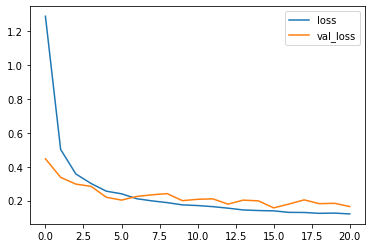

In [47]:
perdidas_mod[['loss','val_loss']].plot()

<AxesSubplot:>

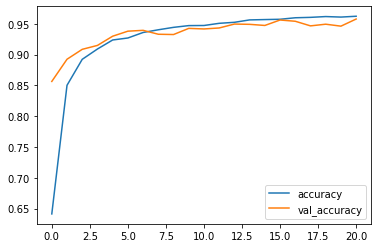

In [48]:
perdidas_mod[['accuracy', 'val_accuracy']].plot()

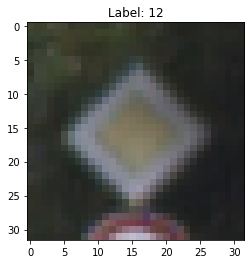

1/1 [==============================] - 0s 75ms/step
Clase predicha: 12


In [49]:
plt.imshow(datos_prueba['features'][7])
plt.title(f"Label: {datos_prueba['labels'][7]}")
plt.show()

# 1. Hacer una predicción para la imagen
probabilidades = modelo_LeNet_modificado.predict(np.expand_dims(X_prueba[7], axis=0))

# 2. Obtener la clase con la mayor probabilidad
clase_predicha = np.argmax(probabilidades, axis=-1)[0]

print("Clase predicha:", clase_predicha)

In [50]:
# 1. Realizar predicciones con el modelo
y_pred = modelo_LeNet_modificado.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades predichas en etiquetas de clase

# 2. Convertir las etiquetas one-hot en etiquetas de clase
y_true = np.argmax(Y_prueba, axis=1)

# 3. Calcular métricas
f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

395/395 [==============================] - 1s 4ms/step
Precision: 0.936604764929874
Recall: 0.9358669833729216
F1-Score: 0.9351820427497542


## Discusión de Resultados

Se evaluaron dos modelos basados en la arquitectura LeNet: el original y una versión modificada. A continuación, se presentan los resultados obtenidos:

### Modelo LeNet Original:
- **Precisión**: 0.9066
- **Recall**: 0.9040
- **F1-Score**: 0.9032

### Modelo LeNet Modificado:
- **Precisión**: 0.9366
- **Recall**: 0.9359
- **F1-Score**: 0.9352

Al analizar las métricas de ambos modelos, se observa que el modelo LeNet modificado supera al original en todas ellas. Estas mejoras son sustanciales, con un incremento aproximado del 3% en cada métrica.

La versión modificada incorpora capas de Batch Normalization y Dropout, lo que ayuda a mejorar la regularización del modelo y a prevenir el sobreajuste. Además, el uso de un mecanismo de detención temprana durante el entrenamiento asegura que el modelo no continúe entrenando más allá del punto en el que el rendimiento en el conjunto de validación empiece a degradarse. 

La superioridad del modelo modificado en términos de rendimiento indica que las adaptaciones hechas a la arquitectura LeNet original, basadas en técnicas modernas, son efectivas para mejorar la clasificación de señales de tráfico. Esta comparación resalta la importancia de considerar técnicas avanzadas de regularización y optimización al diseñar y entrenar redes neuronales para tareas de clasificación.
